In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

VER = 412
USE = 'orders'

# EARLY STOPPING?
VALIDATE = True

CT = 100

In [2]:
import pandas as pd, cudf, numpy as np, gc
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt

In [3]:
users = pd.read_parquet(f'../../data/train_with_features/train_v172_X.pqt')
#users = users.iloc[:1024]
print (users.shape )
users.head()

(13465600, 226)


,user,item,pos,wgt,orders,score_1,score_3,score_4,score_5,score_6,score_7,score_10,score_11,score_12,score_13,score_30,score_14,score_15,score_16,score_17,score_18,score_19,score_20,score_21,score_22,score_23,score_24,score_25,score_26,buy_ratio_5,count_item_5,count_user_5,repeat_5,buy_ratio_std_5,item_day_std_5,user_day_std_5,buy_ratio_0_6,buy_ratio_1_6,buy_ratio_2_6,buy_ratio_3_6,buy_ratio_4_6,buy_ratio_5_6,buy_ratio_6_6,count_item_0_6,count_item_1_6,count_item_2_6,count_item_3_6,count_item_4_6,count_item_5_6,count_item_6_6,count_user_0_6,count_user_1_6,count_user_2_6,count_user_3_6,count_user_4_6,count_user_5_6,count_user_6_6,item_day_std_6,user_day_std_6,buy_ratio,count_item,count_user,hour_mean,day_mean,repeat,buy_ratio_std,hour_std,day_std,buy_ratio3,count_item3,count_user3,hour_mean3,day_mean3,repeat3,buy_ratio_std3,hour_std3,day_std3,prev3,next3,orders3,carts3,order_repeat3,cart_repeat3,buy_ratio2,count_item2,unique_item2,hour_mean2,day_mean2,repeat2,buy_ratio_std2,hour_std2,day_std2,ts_max7,ts_min7,ts_diff7,z1,z2,z3,z4,z5,z6,buy_ratio7,count_item7,count_user7,hour_mean7,day_mean7,repeat7,buy_ratio_std7,hour_std7,day_std7,prev7,next7,orders7,carts7,order_repeat7,cart_repeat7,buy_ratio8,count_item8,count_user8,hour_mean8,day_mean8,repeat8,buy_ratio_std8,hour_std8,day_std8,prev8,next8,orders8,carts8,order_repeat8,cart_repeat8,buy_ratio9,count_item9,count_user9,hour_mean9,day_mean9,repeat9,buy_ratio_std9,hour_std9,day_std9,prev9,next9,orders9,carts9,order_repeat9,cart_repeat9,buy_ratio10,count_item10,unique_item10,hour_mean10,day_mean10,repeat10,buy_ratio_std10,hour_std10,day_std10,z10,z11,buy_ratio11,count_item11,count_user11,hour_mean11,day_mean11,repeat11,buy_ratio_std11,hour_std11,day_std11,buy_ratio12,count_item12,count_user12,hour_mean12,day_mean12,repeat12,buy_ratio_std12,hour_std12,day_std12,buy_ratio13,count_item13,count_user13,hour_mean13,day_mean13,repeat13,buy_ratio_std13,hour_std13,day_std13,buy_ratio14,count_item14,unique_item14,hour_mean14,day_mean14,repeat14,buy_ratio_std14,hour_std14,day_std14,buy_ratio15,count_item15,unique_item15,hour_mean15,day_mean15,repeat15,buy_ratio_std15,hour_std15,day_std15,last_0,last_1,last_2,last_3,last_4,first_0,first_1,first_2,first_3,first_4,buy_0,buy_1,buy_2,buy_3,buy_4,e_mean_0,e_std_0,e_mean_1,e_std_1,e_mean_2,e_std_2,e_mean_3,e_std_3,click_oof
0,11098528,11830,0,-1.000000,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.514214,-1.0,0.671773,-1.0,-1.000,1.414214,1.514214,1.414214,1.414214,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.188454,14481.0,8606.0,1.682663,0.474975,643.345764,643.345764,0.132450,0.173267,0.148649,0.135000,0.115385,0.097744,0.061404,151.0,202.0,222.0,200.0,208.0,133.0,114.0,112.0,130.0,145.0,142.0,156.0,99.0,80.0,42.248135,42.248135,0.175659,32546.0,18362.0,49847.566406,308206.03125,1.772465,0.459607,17870.607422,193386.031250,0.129268,1230.0,849.0,50060.824219,313896.90625,1.448763,0.372407,17396.035156,186814.156250,369.0,372.0,16.0,127.0,1.066667,1.067227,0.0,1.0,1.0,79200.0,338400.0,1.0,-1.0,-1.0,-1.0,0,0,0,1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,0.163253,8153.0,5035.0,48766.132812,309523.93750,1.619265,0.450127,17233.292969,181986.593750,2183.0,2087.0,269.0,793.0,3.086957,2.235294,0.154491,16700.0,10043.0,64008.941406,322344.93750,1.662850,0.430123,10567.528320,193000.531250,4227.0,3740.0,454.0,1672.0,2.224138,2.139628,0.197968,15846.0,9400.0,34922.984375,293305.12500,1.685745,0.487779,10204.664062,192677.828125,4013.0,3537.0,627.0,1883.0,1.958491,1.965084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.233175,4636.0,2785.0,47927.398438,308860.62500,1.664632,0.422898,18213.400391,198956.890625,1.111888,143.0,122.0,48456.414062,334845.21875,1.172131,0.316337,15841.716797,195765.437500,1.111888,143.0,122.0,48456.414062,334845.21875,1.172131,0.316337,15841.716797,195765.4375,0.0,1.0,1.0,79200.0,338400.0,1.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-1.0,-1.0,-1.0,-1.0,1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.000000,0.0,1.000000,0.0,1.

# XGBoost

In [4]:
FEATURES = users.columns[2:]
TARS = [USE]
FEATURES = [f for f in FEATURES if f not in TARS]
print(len(FEATURES))
print( FEATURES)
print(TARS)
#222

223
['pos', 'wgt', 'score_1', 'score_3', 'score_4', 'score_5', 'score_6', 'score_7', 'score_10', 'score_11', 'score_12', 'score_13', 'score_30', 'score_14', 'score_15', 'score_16', 'score_17', 'score_18', 'score_19', 'score_20', 'score_21', 'score_22', 'score_23', 'score_24', 'score_25', 'score_26', 'buy_ratio_5', 'count_item_5', 'count_user_5', 'repeat_5', 'buy_ratio_std_5', 'item_day_std_5', 'user_day_std_5', 'buy_ratio_0_6', 'buy_ratio_1_6', 'buy_ratio_2_6', 'buy_ratio_3_6', 'buy_ratio_4_6', 'buy_ratio_5_6', 'buy_ratio_6_6', 'count_item_0_6', 'count_item_1_6', 'count_item_2_6', 'count_item_3_6', 'count_item_4_6', 'count_item_5_6', 'count_item_6_6', 'count_user_0_6', 'count_user_1_6', 'count_user_2_6', 'count_user_3_6', 'count_user_4_6', 'count_user_5_6', 'count_user_6_6', 'item_day_std_6', 'user_day_std_6', 'buy_ratio', 'count_item', 'count_user', 'hour_mean', 'day_mean', 'repeat', 'buy_ratio_std', 'hour_std', 'day_std', 'buy_ratio3', 'count_item3', 'count_user3', 'hour_mean3', 'day

In [5]:
# LOAD XGB LIBRARY
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb
print('XGB Version',xgb.__version__)

FOLDS = 5
SEED = 42

LR = 0.1

# XGB MODEL PARAMETERS
xgb_parms = { 
    'max_depth':4, 
    'learning_rate':LR, 
    'subsample':0.7,
    'colsample_bytree':0.5, 
    'eval_metric':'map',
    #'objective':'binary:logistic',
    'objective':'rank:pairwise',
    #'scale_pos_weight':3,
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'random_state':SEED
}

XGB Version 1.5.2


In [6]:
# NEEDED WITH DeviceQuantileDMatrix BELOW
class IterLoadForDMatrix(xgb.core.DataIter):
    def __init__(self, df=None, features=None, target=None, batch_size=256*1024):
        self.features = features
        self.target = target
        self.df = df
        self.it = 0 # set iterator to 0
        self.batch_size = batch_size
        self.batches = int( np.ceil( len(df) / self.batch_size ) )
        super().__init__()

    def reset(self):
        '''Reset the iterator'''
        self.it = 0

    def next(self, input_data):
        '''Yield next batch of data.'''
        if self.it == self.batches:
            return 0 # Return 0 when there's no more batch.
        
        a = self.it * self.batch_size
        b = min( (self.it + 1) * self.batch_size, len(self.df) )
        dt = cudf.DataFrame(self.df.iloc[a:b])
        input_data(data=dt[self.features], label=dt[self.target]) #, weight=dt['weight'])
        self.it += 1
        return 1

In [7]:
%%time
USE_LOADER = True

oof = np.zeros(len(users))
importances = []
importances2 = []

skf = GroupKFold(n_splits=FOLDS)
for fold,(train_idx, valid_idx) in enumerate(skf.split(
            X=users, y=users[USE], groups=users.user )):
    
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size BEFORE',len(train_idx),'Valid size',len(valid_idx))
    #train_idxA = users[[USE]].loc[(users.index.isin(train_idx2))&(users[USE]==1)].index.values
    #train_idxB = users[[USE]].loc[(users.index.isin(train_idx2))&(users[USE]==0)].sample(frac=0.85).index.values
    #train_idx = np.concatenate([train_idxA,train_idxB]) 
    print('### Train size AFTER',len(train_idx),'Valid size',len(valid_idx))
    print('#'*25)
    
    # TRAIN, VALID, HOLDOUT FOR FOLD K
    if USE_LOADER:
        Xy_train = IterLoadForDMatrix(users.loc[train_idx], FEATURES, USE)
        if VALIDATE:
            Xy_valid = IterLoadForDMatrix(users.loc[valid_idx], FEATURES, USE)
    else:
        X_train = users.loc[train_idx, FEATURES]
        y_train = users.loc[train_idx,USE]
        if VALIDATE:
            X_valid = users.loc[valid_idx, FEATURES]
            y_valid = users.loc[valid_idx, USE]
            
    if USE_LOADER:
        dtrain = xgb.DeviceQuantileDMatrix(Xy_train, max_bin=256)
        dtrain.set_group( [CT] * ( len(train_idx)//CT) )
        if VALIDATE:
            dvalid = xgb.DeviceQuantileDMatrix(Xy_valid, max_bin=256)
            dvalid.set_group( [CT] * ( len(valid_idx)//CT) )
    else:
        dtrain = xgb.DMatrix(data=X_train, label=y_train, group=[CT] * (len(train_idx)//CT) )
        if VALIDATE:
            dvalid = xgb.DMatrix(data=X_valid, label=y_valid, group=[CT] * (len(valid_idx)//CT) )

    if VALIDATE:
        dd = [(dtrain,'train'),(dvalid,'valid')]
    else:
        dd = [(dtrain,'train')]
    
    # TRAIN MODEL FOLD K
    model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=dd,
                num_boost_round=10_000,
                early_stopping_rounds=200,
                verbose_eval=100)
    model.save_model(f'../../data/models/XGB_fold{fold}_{USE}_v{VER}.xgb')
    
    # GET FEATURE IMPORTANCE FOR FOLD K
    dd = model.get_score(importance_type='weight')
    df = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
    importances.append(df)
    dd = model.get_score(importance_type='gain')
    df = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
    importances2.append(df)
    
    # INFER OOF FOLD K
    if VALIDATE: del dvalid
    del dtrain 
    gc.collect()
    
    print('inferring first half...')
    valid_idxA = valid_idx[:len(valid_idx)//2]
    dvalid = xgb.DMatrix(data=users.loc[valid_idxA, FEATURES]) 
    oof_preds = model.predict(dvalid)
    oof[valid_idxA] = oof_preds
    del dvalid
    gc.collect()
    
    print('inferring second half...')
    valid_idxA = valid_idx[len(valid_idx)//2:]
    dvalid = xgb.DMatrix(data=users.loc[valid_idxA, FEATURES]) 
    oof_preds = model.predict(dvalid)
    oof[valid_idxA] = oof_preds
    
    if USE_LOADER: 
        del Xy_train 
        if VALIDATE: 
            del Xy_valid
    else: 
        del X_train, y_train
        if VALIDATE:
            X_valid, y_valid
    del dd, df, dvalid, model
    gc.collect()
    
# [1661]	train-map:0.77411	valid-map:0.76306
# [2522]	train-map:0.77633	valid-map:0.77309

#########################
### Fold 1
### Train size BEFORE 10772400 Valid size 2693200
### Train size AFTER 10772400 Valid size 2693200
#########################
[0]	train-map:0.68427	valid-map:0.70071
[100]	train-map:0.75340	valid-map:0.74701
[200]	train-map:0.75985	valid-map:0.75294
[300]	train-map:0.76363	valid-map:0.75616
[400]	train-map:0.76604	valid-map:0.75829
[500]	train-map:0.76762	valid-map:0.76015
[600]	train-map:0.76861	valid-map:0.76085
[700]	train-map:0.76983	valid-map:0.76184
[800]	train-map:0.77063	valid-map:0.76247
[900]	train-map:0.77150	valid-map:0.76247
[1000]	train-map:0.77195	valid-map:0.76310
[1100]	train-map:0.77254	valid-map:0.76351
[1200]	train-map:0.77291	valid-map:0.76397
[1300]	train-map:0.77336	valid-map:0.76411
[1400]	train-map:0.77393	valid-map:0.76441
[1500]	train-map:0.77434	valid-map:0.76427
[1600]	train-map:0.77454	valid-map:0.76406
[1603]	train-map:0.77447	valid-map:0.76401
inferring first half...
inferring second half...
#########################
#

In [8]:
USR = users['user'].unique()
len(USR)

134656

In [9]:
#np.save(f'/raid/Kaggle/otto/data16/oof{VER}_usr',USR)

In [10]:
#np.save(f'/raid/Kaggle/otto/data16/oof{VER}',oof)

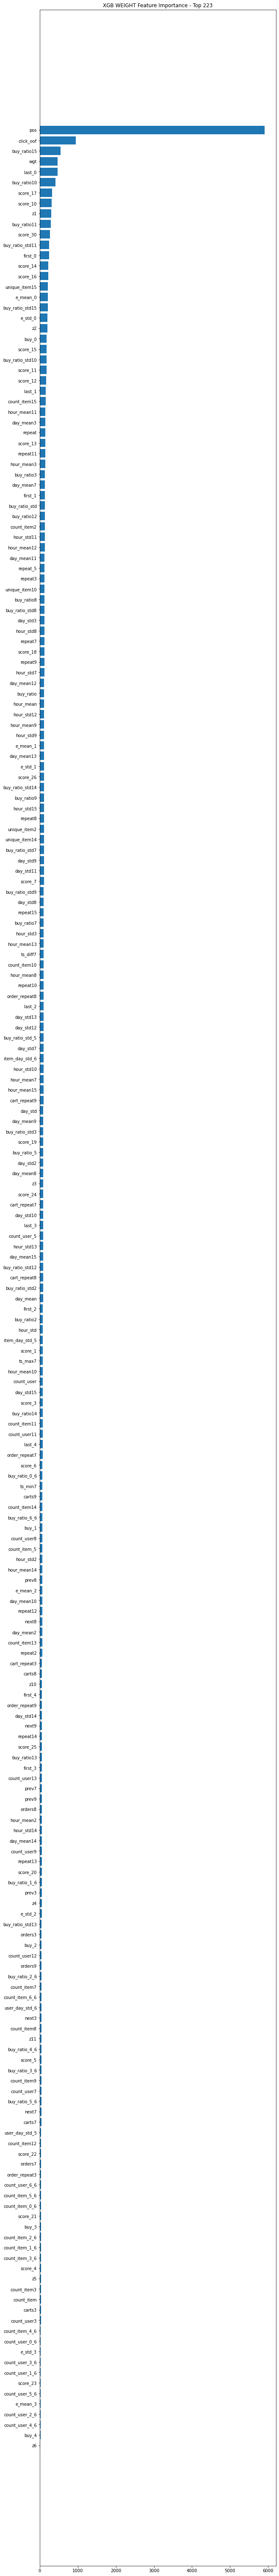

In [11]:
df = importances[0].copy()
for k in range(1,FOLDS): df = df.merge(importances[k], on='feature', how='left')
df['importance'] = df.iloc[:,1:].mean(axis=1)
df = df.sort_values('importance',ascending=False)
#df.to_csv(f'feats_weight_{USE}_{VER}.csv',index=False)
NUM_FEATURES = len(df)
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES])
plt.title(f'XGB WEIGHT Feature Importance - Top {NUM_FEATURES}')
plt.show()

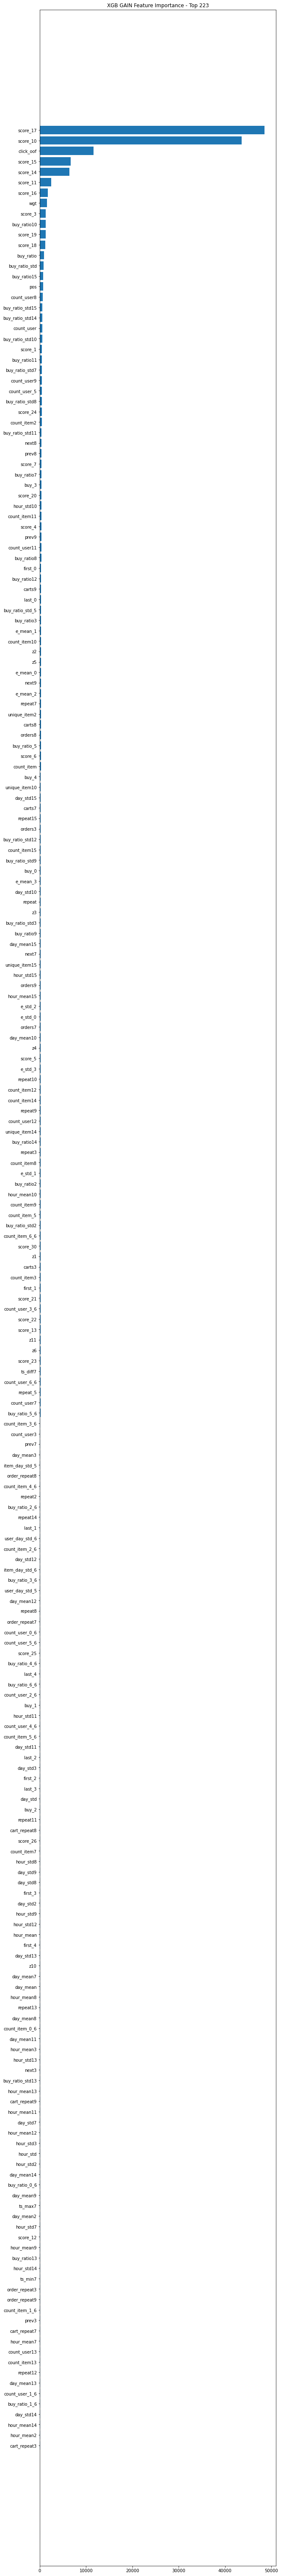

In [12]:
df = importances2[0].copy()
for k in range(1,FOLDS): df = df.merge(importances2[k], on='feature', how='left')
df['importance'] = df.iloc[:,1:].mean(axis=1)
df = df.sort_values('importance',ascending=False)
df.to_csv(f'feats_gain_{USE}_{VER}.csv',index=False)
NUM_FEATURES = len(df)
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES])
plt.title(f'XGB GAIN Feature Importance - Top {NUM_FEATURES}')
plt.show()

# Make Sub

In [13]:
sub = users[['user','item']].copy()
sub['p'] = oof
#sub = cudf.DataFrame(sub)
sub = sub.sort_values(['user','p'],ascending=[True,False])
print( sub.shape )
sub.head()

(13465600, 3)


,user,item,p
0,11098528,11830,4.067614
1,11098528,1732105,2.441766
2,11098528,588923,0.902310
6,11098528,876129,0.854653
4,11098528,884502,0.808670


In [14]:
sub = sub.reset_index(drop=True)

In [15]:
sub['n'] = sub.groupby('user').item.cumcount().astype('int8')

In [16]:
sub.head()

,user,item,p,n
0,11098528,11830,4.067614,0
1,11098528,1732105,2.441766,1
2,11098528,588923,0.902310,2
3,11098528,876129,0.854653,3
4,11098528,884502,0.808670,4


In [17]:
sub = sub.loc[sub.n<20]
print( sub.shape )

(2693120, 4)


In [18]:
#sub = sub.to_pandas()

In [19]:
%%time
sub2 = sub.groupby('user').item.apply(list)

CPU times: user 2.24 s, sys: 48.1 ms, total: 2.29 s
Wall time: 2.29 s


In [20]:
sub2 = sub2.to_frame().reset_index()

In [21]:
%%time
sub2.item = sub2.item.apply(lambda x: " ".join(map(str,x)))

CPU times: user 521 ms, sys: 16.2 ms, total: 537 ms
Wall time: 535 ms


In [22]:
sub2.columns = ['session_type','labels']

In [23]:
sub2.session_type = sub2.session_type.astype('str')+ f'_{USE}'

In [24]:
sub2.head()

,session_type,labels
0,11098528_orders,11830 1732105 588923 876129 884502 1157882 571...
1,11098530_orders,409236 264500 1603001 364155 963957 583026 254...
2,11098531_orders,1557766 1271998 1365569 452188 1032999 396199 ...
3,11098533_orders,1074173 1309900 1165015 1803426 86580 765030 9...
4,11098534_orders,223062 1449202 908024 1607945 1342293 1300062 ...


In [25]:
submission = sub2

In [26]:
def fill_up(x):
    return []

In [27]:
%%time
submission['session'] = submission.session_type.apply(lambda x: int(x.split('_')[0]))
submission['type'] = submission.session_type.apply(lambda x: x.split('_')[1])
submission.labels = submission.labels.apply(lambda x: [int(i) for i in x.split(' ')[:20]])

test_labels = pd.read_parquet('/raid/Kaggle/otto/valid/test_labels.parquet')
test_labels = test_labels.loc[test_labels['type']==USE]

test_labels = test_labels.merge(submission, how='left', on=['session', 'type'])
test_labels.loc[test_labels.labels.isna(),'labels'] =\
    test_labels.loc[test_labels.labels.isna(),'labels'].map(fill_up)

test_labels['hits'] = test_labels.apply(lambda df: len(set(df.ground_truth).intersection(set(df.labels))), axis=1)
test_labels['gt_count'] = test_labels.ground_truth.str.len().clip(0,20)

recall_per_type = test_labels.groupby(['type'])['hits'].sum() / test_labels.groupby(['type'])['gt_count'].sum() 

score = (recall_per_type * pd.Series({'clicks': 0.10, 'carts': 0.30, 'orders': 0.60})).sum()
print( score , recall_per_type)

#orders    0.668165 v411 best
#orders    0.668704 v11 with giba

0.40146950396261766 type
orders    0.669116
dtype: float64
CPU times: user 5.78 s, sys: 261 ms, total: 6.04 s
Wall time: 5.81 s


In [28]:
0.3*0.435922 + 0.1*0.551342 + 0.6*0.665608

0.5852755999999999